In [1]:
import os

import numpy as np
import pandas as pd

from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

import joblib
from joblib import Parallel, delayed

import cv2
import matplotlib.pyplot as plt

In [2]:
path_brain_images = os.path.join("agyikepek_3_osztaly", "kepek")

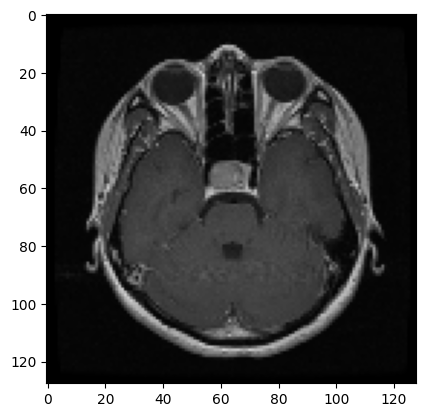

In [3]:
IMG_DIR = os.listdir(path_brain_images)
IMG_COUNT = len(IMG_DIR)
IMG_SHAPE = (128, 128, 3)
img = cv2.imread(os.path.join(path_brain_images, IMG_DIR[0]))
img = cv2.resize(img, (IMG_SHAPE[1], IMG_SHAPE[0]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

In [4]:
def save_images(PATH, img_count, img_shape) -> pd.DataFrame:
    
    images = np.zeros((img_count, *img_shape), dtype=np.uint8)
    types = np.zeros(img_count, dtype=np.int32)

    for i, file_name in enumerate(os.listdir(PATH), 0):
        img = cv2.imread(os.path.join(PATH, file_name))
        img_type = int(file_name.split("_")[1][0])

        if img.shape != img_shape:
            img = cv2.resize(img, IMG_SHAPE[:2])
            print(f"resize {file_name}")

        images[i] = img
        types[i] = img_type

        if i % 100 == 0:
            print(f"{i} images read")
    
    print(f"all {i + 1} images were read")
    df = pd.DataFrame({"img": list(images), "type": types})
    return df

In [5]:
df = save_images(path_brain_images, IMG_COUNT, IMG_SHAPE)

resize 1000_3.png
0 images read
resize 1001_3.png
resize 1002_3.png
resize 1003_3.png
resize 1004_3.png
resize 1005_3.png
resize 1006_3.png
resize 1007_3.png
resize 1008_3.png
resize 1009_3.png
resize 100_1.png
resize 1010_3.png
resize 1011_3.png
resize 1012_3.png
resize 1013_3.png
resize 1014_3.png
resize 1015_3.png
resize 1016_3.png
resize 1017_3.png
resize 1018_3.png
resize 1019_3.png
resize 101_1.png
resize 1020_3.png
resize 1021_3.png
resize 1022_3.png
resize 1023_3.png
resize 1024_3.png
resize 1025_3.png
resize 1026_3.png
resize 1027_3.png
resize 1028_3.png
resize 1029_3.png
resize 102_1.png
resize 1030_3.png
resize 1031_3.png
resize 1032_3.png
resize 1033_3.png
resize 1034_3.png
resize 1035_3.png
resize 1036_3.png
resize 1037_3.png
resize 1038_3.png
resize 1039_3.png
resize 103_1.png
resize 1040_3.png
resize 1041_3.png
resize 1042_3.png
resize 1043_3.png
resize 1044_3.png
resize 1045_3.png
resize 1046_3.png
resize 1047_3.png
resize 1048_3.png
resize 1049_3.png
resize 104_1.png
r

In [6]:
df["type"].value_counts()

type
2    1426
3     930
1     708
Name: count, dtype: int64

In [7]:
X = df["img"]
y = df["type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=32, stratify=y)

In [8]:
y_train.value_counts()

type
2    1283
3     837
1     637
Name: count, dtype: int64

In [9]:
y_test.value_counts()

type
2    143
3     93
1     71
Name: count, dtype: int64

In [10]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [11]:
def apply_thresholding(img: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, th1 = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
    th2 = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                cv2.THRESH_BINARY, 11, 2)
    th3 = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, 11, 2)
    return th1, th2, th3

In [12]:
def fuzzy_cmeans(img: np.ndarray, k=6, med_blur=1) -> np.ndarray:
    if img.ndim == 3:
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        image = img
    
    pixel_vals = image.reshape((-1, img.shape[-1] if img.ndim == 3 else 1)).astype(np.float32)
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    
    _, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 5, cv2.KMEANS_PP_CENTERS)
    
    segmented_image = centers[labels.flatten()].reshape(image.shape).astype(np.uint8)
    
    if med_blur > 1:
        segmented_image = cv2.medianBlur(segmented_image, med_blur)
    
    return segmented_image

In [13]:
print(type(X_train))
print(type(X_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


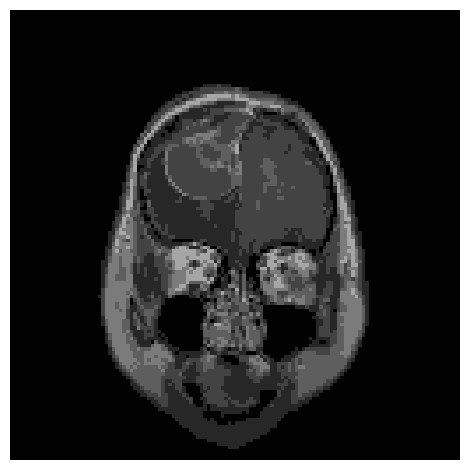

In [14]:
types = ["meningioma", "glioma", "pituitary"]
sampled_images = X_train[0]

th1, th2, _ = apply_thresholding(cv2.cvtColor(sampled_images, cv2.COLOR_BGR2RGB))
fuzzy = fuzzy_cmeans(sampled_images)
img_type = "Thresholded"
file_name = "asd"

plt.imshow(fuzzy, cmap="gray")
plt.axis("off")


plt.tight_layout()
plt.show()

In [16]:
def preprocess_dataset(X: np.ndarray) -> np.ndarray:

    processed_images = []
    for img in X:
        th1, th2, th3 = apply_thresholding(img)
        fuzzy = fuzzy_cmeans(img)
        
        flattened = np.concatenate([fuzzy.flatten(), th1.flatten(), th2.flatten()])
        processed_images.append(flattened)
    return np.array(processed_images)

X_train_flattened = preprocess_dataset(X_train)
X_test_flattened = preprocess_dataset(X_test)

print(f"X_train_flattened shape: {X_train_flattened.shape}")
print(f"X_test_flattened shape: {X_test_flattened.shape}")


X_train_flattened shape: (2757, 81920)
X_test_flattened shape: (307, 81920)


accuracy=0.9120521172638436
f1=0.9120521172638436
recall=0.9120521172638436
precision=0.9120521172638436
RandomForrest:
              precision    recall  f1-score   support

           1     0.8871    0.7746    0.8271        71
           2     0.9110    0.9301    0.9204       143
           3     0.9293    0.9892    0.9583        93

    accuracy                         0.9121       307
   macro avg     0.9091    0.8980    0.9019       307
weighted avg     0.9110    0.9121    0.9103       307



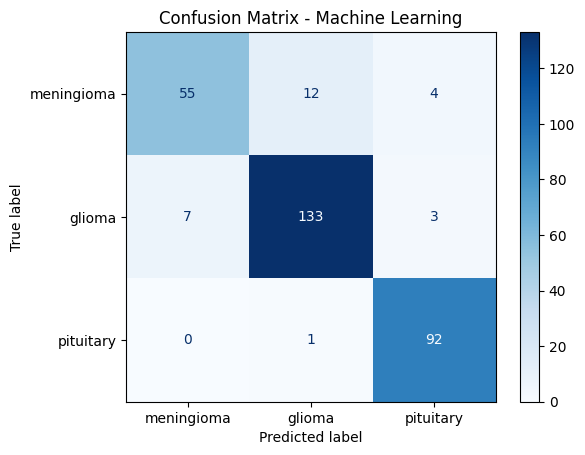

In [20]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100, max_depth=9)
model.fit(X_train_flattened, y_train)

y_pred = model.predict(X_test_flattened)

rf_accuracy = accuracy_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred, average="micro")
rf_recall = recall_score(y_test, y_pred, average="micro")
rf_precision = precision_score(y_test, y_pred, average="micro")

print(f"accuracy={rf_accuracy}")
print(f"f1={rf_f1}")
print(f"recall={rf_recall}")
print(f"precision={rf_precision}")

brain_labels = ["meningioma", "glioma", "pituitary"]

print("RandomForrest:")
print(classification_report(y_true=y_test, y_pred=y_pred, digits=4))

brain_labels = ["meningioma", "glioma", "pituitary"] # agyhártyadaganat - agydaganat - agyalapi mirigy

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= brain_labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Machine Learning' )
plt.savefig("conf_mx_ml.jpg")